In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

In [3]:
train = pd.read_csv('train_E6oV3lV.csv')
test = pd.read_csv('test_tweets_anuFYb8.csv')

In [4]:
train.head

<bound method NDFrame.head of           id  label                                              tweet
0          1      0   @user when a father is dysfunctional and is s...
1          2      0  @user @user thanks for #lyft credit i can't us...
2          3      0                                bihday your majesty
3          4      0  #model   i love u take with u all the time in ...
4          5      0             factsguide: society now    #motivation
5          6      0  [2/2] huge fan fare and big talking before the...
6          7      0   @user camping tomorrow @user @user @user @use...
7          8      0  the next school year is the year for exams.ð...
8          9      0  we won!!! love the land!!! #allin #cavs #champ...
9         10      0   @user @user welcome here !  i'm   it's so #gr...
10        11      0   â #ireland consumer price index (mom) climb...
11        12      0  we are so selfish. #orlando #standwithorlando ...
12        13      0  i get to see my daddy toda

In [5]:
combi = train.append(test,ignore_index = True,sort = True)

In [44]:
import re #regular expression
def remove_pattern(input_txt,pattern):
    r = re.findall(pattern,input_txt)
    for i in r:
        input_txt = re.sub(i,'',input_txt)#sub(characters we want to keep, removed character replaced by space, string to work on)
        
    return input_txt


In [45]:
# remove twitter handles (@user)
#“@[\w]*” - regular expression which will pick any word starting with ‘@’.
combi['tidy_tweet'] = np.vectorize(remove_pattern)(combi['tweet'], "@[\w]*")

In [46]:
# remove special characters, numbers, punctuations
import string
combi['tidy_tweet'] = combi['tidy_tweet'].str.replace("[^a-zA-Z#]", " ")

In [47]:
# removing short words
combi['tidy_tweet'] = combi['tidy_tweet'].apply(lambda x: ' '.join([w for w in x.split() if len(w)>3 ]))

In [48]:
combi.head()

,id,label,tweet,tidy_tweet
0,1,0.0,@user when a father is dysfunctional and is s...,when father dysfunctional selfish drags kids i...
1,2,0.0,@user @user thanks for #lyft credit i can't us...,thanks #lyft credit cause they offer wheelchai...
2,3,0.0,bihday your majesty,bihday your majesty
3,4,0.0,#model i love u take with u all the time in ...,#model love take with time
4,5,0.0,factsguide: society now #motivation,factsguide society #motivation


In [49]:
#Tokenization
tokenized_tweet = combi['tidy_tweet'].apply(lambda x: x.split())


In [50]:
tokenized_tweet.head()

0    [when, father, dysfunctional, selfish, drags, ...
1    [thanks, #lyft, credit, cause, they, offer, wh...
2                              [bihday, your, majesty]
3                     [#model, love, take, with, time]
4                   [factsguide, society, #motivation]
Name: tidy_tweet, dtype: object

In [51]:
#Stemming
import nltk
from nltk.stem.porter import *
stemmer = PorterStemmer()
tokenized_tweet = tokenized_tweet.apply(lambda x : [stemmer.stem(i) for i in x])
tokenized_tweet.head()

0    [when, father, dysfunct, selfish, drag, kid, i...
1    [thank, #lyft, credit, caus, they, offer, whee...
2                              [bihday, your, majesti]
3                     [#model, love, take, with, time]
4                         [factsguid, societi, #motiv]
Name: tidy_tweet, dtype: object

In [52]:
for i in range(len(tokenized_tweet)):
    tokenized_tweet[i] = ' '.join(tokenized_tweet[i])

combi['tidy_tweet'] = tokenized_tweet

In [53]:
#wordcloud is a visualization wherein the most frequent words appear in large size and the less frequent words appear in smaller sizes.
#not working in jupyter ..try it later
all_words = ' '.join([text for text in combi['tidy_tweet']])



In [54]:
normal_words =' '.join([text for text in combi['tidy_tweet'][combi['label'] == 0]])

In [55]:
negative_words = ' '.join([text for text in combi['tidy_tweet'][combi['label'] == 1]])

In [56]:
#Understanding impact of Hastags on sentiment
# function to collect hashtags
def hashtag_extract(x):
    hashtags = []
    # Loop over the words in the tweet
    for i in x:
        ht = re.findall(r"#(\w+)", i)
        hashtags.append(ht)

    return hashtags

In [57]:
# extracting hashtags from non racist/sexist tweets

HT_regular = hashtag_extract(combi['tidy_tweet'][combi['label'] == 0])

# extracting hashtags from racist/sexist tweets
HT_negative = hashtag_extract(combi['tidy_tweet'][combi['label'] == 1])

# unnesting list
HT_regular = sum(HT_regular,[])
HT_negative = sum(HT_negative,[])

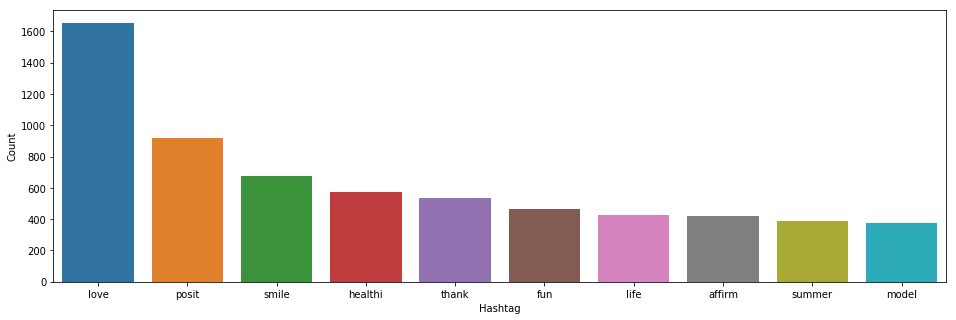

In [58]:
import seaborn as sns
a = nltk.FreqDist(HT_regular)
d = pd.DataFrame({'Hashtag': list(a.keys()),
                  'Count': list(a.values())})
# selecting top 10 most frequent hashtags     
d = d.nlargest(columns="Count", n = 10) 
plt.figure(figsize=(16,5))
ax = sns.barplot(data=d, x= "Hashtag", y = "Count")
ax.set(ylabel = 'Count')
plt.show()

In [59]:
# Bag of words

from sklearn.feature_extraction.text import CountVectorizer
bow_vectorizer = CountVectorizer(max_df=0.90, min_df=2, max_features=1000, stop_words='english')
# bag-of-words feature matrix
bow = bow_vectorizer.fit_transform(combi['tidy_tweet'])

In [60]:
#TF-IDF
from sklearn.feature_extraction.text import TfidfVectorizer
tfidf_vectorizer = TfidfVectorizer(max_df=0.90, min_df=2, max_features=1000, stop_words='english')
# TF-IDF feature matrix
tfidf = tfidf_vectorizer.fit_transform(combi['tidy_tweet'])

In [61]:
#On Bag of Words Model
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import f1_score

train_bow = bow[:31962,:]
test_bow = bow[31962:,:]

# splitting data into training and validation set
xtrain_bow, xvalid_bow, ytrain, yvalid = train_test_split(train_bow, train['label'], random_state=42, test_size=0.3)

lreg = LogisticRegression()
lreg.fit(xtrain_bow, ytrain) # training the model

prediction = lreg.predict_proba(xvalid_bow) # predicting on the validation set
prediction_int = prediction[:,1] >= 0.3 # if prediction is greater than or equal to 0.3 than 1 else 0
prediction_int = prediction_int.astype(np.int)

f1_score(yvalid, prediction_int) # calculating f1 score

0.5307820299500832

In [62]:
test_pred = lreg.predict_proba(test_bow)
test_pred_int = test_pred[:,1] >= 0.3
test_pred_int = test_pred_int.astype(np.int)
test['label'] = test_pred_int
submission = test[['id','label']]
submission.to_csv('sub_lreg_bow.csv', index=False) # writing data to a CSV file

In [38]:
#on TF-IDF
train_tfidf = tfidf[:31962,:]
test_tfidf = tfidf[31962:,:]

xtrain_tfidf = train_tfidf[ytrain.index]
xvalid_tfidf = train_tfidf[yvalid.index]

lreg.fit(xtrain_tfidf, ytrain)

prediction = lreg.predict_proba(xvalid_tfidf)
prediction_int = prediction[:,1] >= 0.3
prediction_int = prediction_int.astype(np.int)

f1_score(yvalid, prediction_int)

0.5477031802120143